<a href="https://colab.research.google.com/github/drago467/Deep-Facial-Recognition-App/blob/main/Facial%20Verification%20with%20a%20Siamese%20Network_Train%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:

# Import tensorflow depencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [7]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset

!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

!tar -xf lfw.tgz

--2024-09-16 11:27:53--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  1.05MB/s    in 7m 7s   

2024-09-16 11:35:01 (413 KB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [8]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    # Tạo đường dẫn đầy đủ đến thư mục con
    directory_path = os.path.join('lfw', directory)

    # Kiểm tra nếu đường dẫn là một thư mục
    if os.path.isdir(directory_path):
        for file in os.listdir(directory_path):
            EX_PATH = os.path.join(directory_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)

In [9]:
 # Import uuid library to generate unique image names
 import uuid

 # Establish a connection to the webcam
 cap = cv2.VideoCapture(4)
 while cap.isOpened():
  ret, frame = cap.read()

  # Cut down  frame to 250x250px
  frame = frame[120:120+250,200:200+250, :]

  # Collect anchors
  if cv2.waitKey(1) & 0XFF == ord('a'):
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)

  # Collect possitives
  if cv2.waitKey(1) & 0XFF == ord('p'):
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)

  # Show image back to screen
  cv2.imshow('Image Collection', frame)

  # Breaking gracefully
  if cv2.waikey(1) & OXFF == ord('q'):
    break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
import os

# Tạo thư mục đích nếu chưa tồn tại
destination_dir = '/content/data/anchor'
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Sao chép tất cả các tệp ảnh (.jpg, .jpeg, .png) từ Google Drive
!cp /content/drive/MyDrive/anchor/*.{jpg,jpeg,png} /content/data/anchor/


cp: cannot stat '/content/drive/MyDrive/anchor/*.jpeg': No such file or directory
cp: cannot stat '/content/drive/MyDrive/anchor/*.png': No such file or directory


In [12]:
import os

# Tạo thư mục đích nếu chưa tồn tại
destination_dir = '/content/data/positive'
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Sao chép tất cả các tệp ảnh (.jpg, .jpeg, .png) từ Google Drive
!cp /content/drive/MyDrive/positive/*.{jpg,jpeg,png} /content/data/positive/


cp: cannot stat '/content/drive/MyDrive/positive/*.jpeg': No such file or directory
cp: cannot stat '/content/drive/MyDrive/positive/*.png': No such file or directory


In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [14]:
dir_test = negative.as_numpy_iterator()
dir_test.next()

b'data/negative/Alvaro_Uribe_0024.jpg'

#**3.2 Preprocessing - Scale and Resize**

In [15]:
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img, (100,100))
  img = img / 255.0
  return img

## **3.3 Create Labelled Dataset**

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [17]:
samples = data.as_numpy_iterator()

In [18]:
samples.next()

(b'data/anchor/c921cbaa-72af-11ef-bf81-701ab85ee0c9.jpg',
 b'data/positive/ca8fd297-72b0-11ef-81d1-701ab85ee0c9.jpg',
 1.0)

In [19]:
samples.next()[0]

b'data/anchor/d4c38589-72af-11ef-b82e-701ab85ee0c9.jpg'

## **3.4 Build Train and Test Partition**

In [20]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [21]:
res = preprocess_twin(*samples.next())

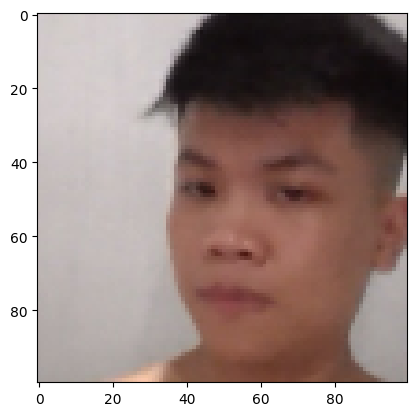

In [22]:
plt.imshow(res[1])

In [23]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [63]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [73]:
# Testing partition
test_data = data.take(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [24]:
samples = data.as_numpy_iterator()

In [25]:
samp = samples.next()

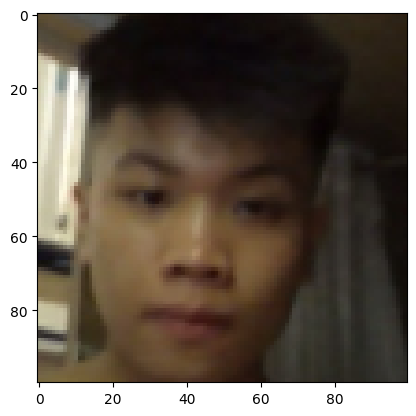

In [26]:
plt.imshow(samp[1])

# **4. Model Engineering**

## **4.1 Build Embedding Layer**

In [27]:
inp = Input( shape=(100, 100, 3), name='input_image')

# First block
c1 = Conv2D(64, (10, 10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

# Second block
c2 = Conv2D(128, (7, 7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

# Third block
c3 = Conv2D(128, (4, 4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

# Final ebedding block
c4 = Conv2D(256, (4, 4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [28]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [29]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
def make_embedding():
  inp = Input( shape=(100, 100, 3), name='input_image')

  # First block
  c1 = Conv2D(64, (10, 10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

  # Second block
  c2 = Conv2D(128, (7, 7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

  # Third block
  c3 = Conv2D(128, (4, 4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

  # Final ebedding block
  c4 = Conv2D(256, (4, 4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [31]:
embedding = make_embedding()

In [32]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## **4.2 Build Distance Layer**

In [65]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        # Kiểm tra kiểu dữ liệu và xử lý nếu cần thiết
        if isinstance(input_embedding, list):
            input_embedding = input_embedding[0]
        if isinstance(validation_embedding, list):
            validation_embedding = validation_embedding[0]

        return tf.math.abs(input_embedding - validation_embedding)

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [45]:
l1 = L1Dist()

In [46]:
l1

<L1Dist name=l1_dist_2, built=False>

## **4.3 Make Siamese Model**

In [67]:
def make_siamese_model():

  # Anchor image input in the network
  input_image = Input(name='input_img', shape=(100, 100, 3))

  # Validation image in the network
  validation_image = Input(name='validation_img', shape=(100, 100, 3))

  # Combine siamese distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # Classification Layer
  classifier = Dense(1, activation='sigmoid')(distances)
  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


siamese_model = make_siamese_model()

# **5. Trainning**

## **5.1 Setup Loss and Optimizer**

In [56]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [57]:
opt = tf.keras.optimizers.Adam(1e-4)

## **5.2 Establish Checkpoints**

In [58]:
checkpoint_dir = './training_checkpoints'
# os.makedirs('training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## **5.3 Build Train Step Function**

In [69]:
@tf.function
def train_step(batch):
    X = batch[:2]
    y = batch[2]

    with tf.GradientTape() as tape:
        # Phép toán tiến
        yhat = siamese_model(X, training=True)
        # Tính toán mất mát
        loss = binary_cross_loss(y, yhat)

    # In ra mất mát (nên sử dụng thận trọng trong việc đào tạo thực tế)
    print(loss)

    # Tính toán gradient
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Áp dụng gradient
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss


## **5.4 Build Training Loop**

In [70]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS + 1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            # Thực hiện bước đào tạo ở đây
            train_step(batch)
            progbar.update(idx + 1)

        progbar = tf.keras.utils.Progbar(len(data))

        # Lưu checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## **5.5 Train the model**

In [71]:
EPOCHS = 50

In [72]:
train(train_data, EPOCHS)


Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step

Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step

Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step

Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step

Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step

Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step

Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step

Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step

Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step

Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step

Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step

Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step

Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step

Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step

Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step

Epoch 16/50
27/27 ━━━━━━━━━━

## **6.Evaluate Model**

## **6.1 Import Metrics**

In [74]:
# Import metrics calculations
from tensorflow.keras.metrics import Precision, Recall

## **6.2 Make Predictions**

In [77]:
# Get a batch of testdata
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [79]:
test_var = test_data.as_numpy_iterator().next()

In [80]:
len(test_var)

3

In [82]:
len(test_var[1])

16

In [83]:
y_true

array([0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
      dtype=float32)

In [86]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [87]:
y_hat

array([[6.3115399e-06],
       [9.9999690e-01],
       [2.7798720e-05],
       [9.9993634e-01],
       [9.9777573e-01],
       [3.9104114e-07],
       [9.9891174e-01],
       [9.9029797e-01],
       [1.6096828e-07],
       [4.6534093e-05],
       [2.5667259e-05],
       [4.1453184e-08],
       [1.0000000e+00],
       [9.9995542e-01],
       [9.9831104e-01],
       [2.2546003e-05]], dtype=float32)

In [88]:
# Post preocessing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]

In [89]:
y_true

array([0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
      dtype=float32)

## **6.3 Calculate Metrics**

In [91]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

## **6.4 Viz Results**

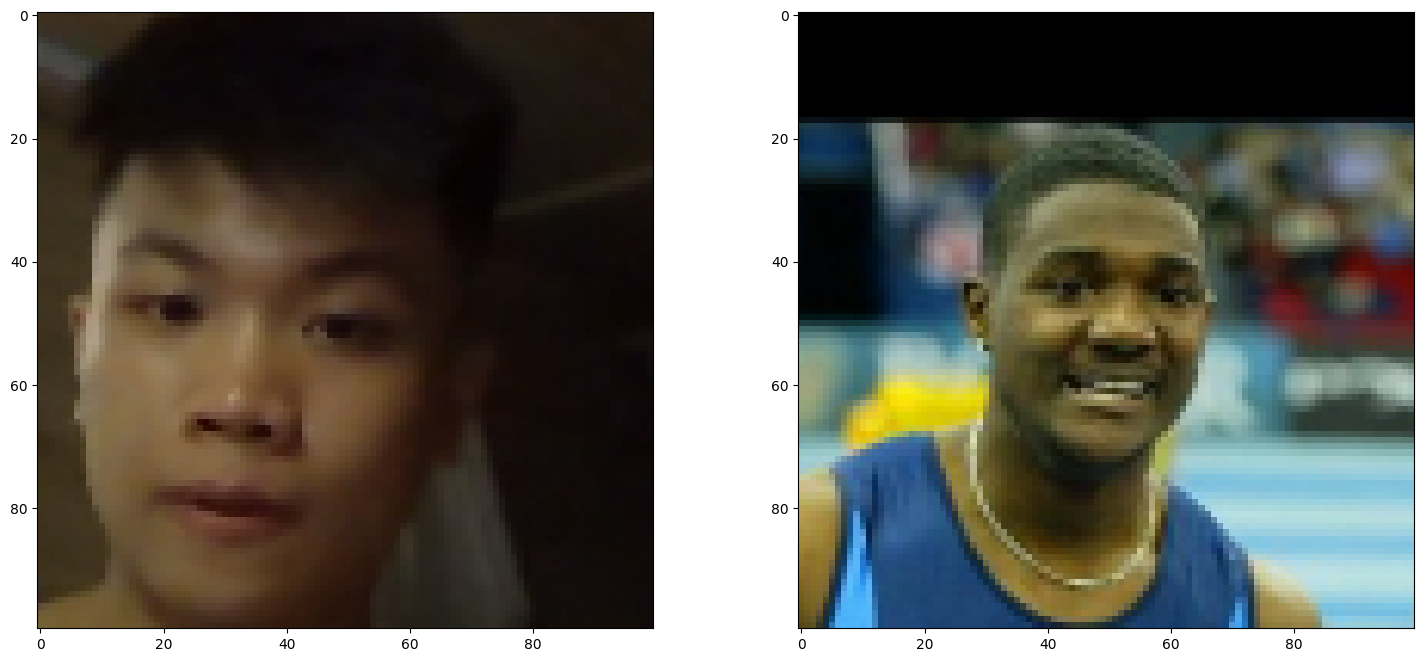

In [97]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[2])
plt.subplot(1, 2, 2)
plt.imshow(test_val[2])
plt.show()

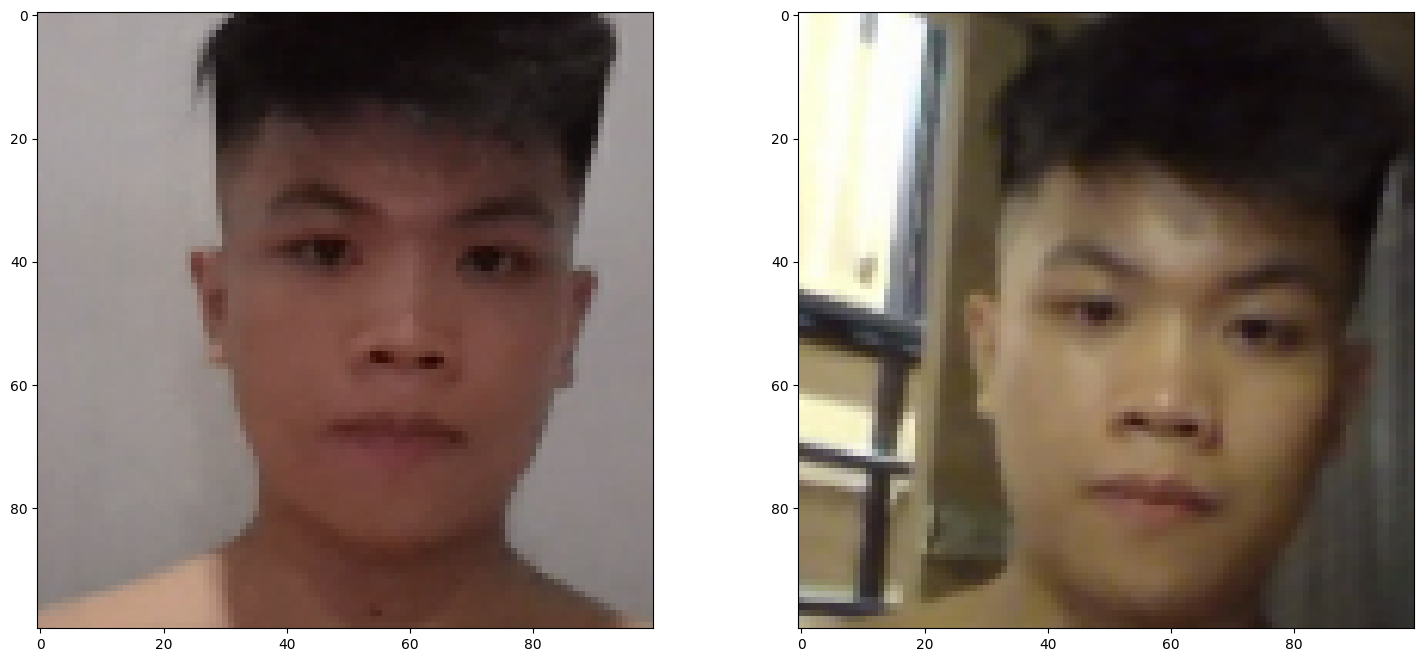

In [98]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[3])
plt.subplot(1, 2, 2)
plt.imshow(test_val[3])
plt.show()

## **7. Save Model**

In [99]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [103]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [104]:
L1Dist

__main__.L1Dist

In [105]:
# Make predictions with reload model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


array([[6.3115399e-06],
       [9.9999690e-01],
       [2.7798720e-05],
       [9.9993634e-01],
       [9.9777573e-01],
       [3.9104114e-07],
       [9.9891174e-01],
       [9.9029797e-01],
       [1.6096828e-07],
       [4.6534093e-05],
       [2.5667259e-05],
       [4.1453184e-08],
       [1.0000000e+00],
       [9.9995542e-01],
       [9.9831104e-01],
       [2.2546003e-05]], dtype=float32)

In [106]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)    │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_img[0][0],       │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_9 (L1Dist)        │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_9[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)